In [24]:
import ee
import geemap
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Authenticate to Earth Engine
try:
  ee.Initialize()
except Exception as e:
  ee.Authenticate()
  ee.Initialize(project='ee-ana-zonia')

modis = ee.ImageCollection("MODIS/061/MCD12Q1")
esa_2020 = ee.ImageCollection("ESA/WorldCover/v100")
esa_2021 = ee.ImageCollection("ESA/WorldCover/v200")
roi = ee.FeatureCollection("projects/ee-ana-zonia/assets/PAN_roi_piedra_piura")

districts = ee.FeatureCollection("projects/ee-ana-zonia/assets/PAN_distritos_2022")
piura_shp = ee.FeatureCollection('projects/envr451-2024/assets/piura').geometry()

In [6]:
def print_info(featcol):
  # Get a list of features from the Feature Collection
  features = featcol.getInfo()['features']

  # Iterate over each feature and print the district and ID if the district is in the Veraguas province
  for feature in features:
      properties = feature['properties']
      if properties.get('PROVINCIA') == "Veraguas":
        district = properties.get('DISTRITO')
        id_dist = properties.get('ID_DIST')
        id_prov = properties.get('COD_PROV')
        print(f'District: {district}, ID: {id_dist}, ID_Province: {id_prov}')

# So, if we want data for Santa Fe in Veraguas only (there's two santa fe in Panama):
santa_fe = districts.filter(ee.Filter.eq("ID_DIST", '0909')).geometry()

In [12]:
# clipping image collections to area of interest
esa_2020_pp = esa_2020.map(lambda image: image.clip(roi)).first()
esa_2021_pp = esa_2021.map(lambda image: image.clip(roi)).first()

# Define visualization parameters
visualization = {'bands': ['Map']}

Map = geemap.Map()
Map.centerObject(piura_shp)
Map.addLayer(esa_2020_pp, visualization, 'esa_2020_pp')
Map.addLayer(piura_shp, {})
Map.add_legend(title="ESA Land Cover", builtin_legend='ESA_WorldCover')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### MODIS

In [15]:
modis_pp = modis.map(lambda image: image.clip(piura_shp)).select('LC_Type1')

igbpLandCoverVis = {
    'min': 1.0,
    'max': 17.0,
    'palette': [
        '05450a',
        '086a10',
        '54a708',
        '78d203',
        '009900',
        'c6b044',
        'dcd159',
        'dade48',
        'fbff13',
        'b6ff05',
        '27ff87',
        'c24f44',
        'a5a5a5',
        'ff6d4c',
        '69fff8',
        'f9ffa4',
        '1c0dff',
    ],
}

Map = geemap.Map()
Map.center_object(piura_shp)
Map.add_time_slider(modis_pp, igbpLandCoverVis, time_interval = 2)
# Map.addLayer(piura_shp, {})
Map.add_legend(title="MODIS", builtin_legend="MODIS/006/MCD12Q1")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [74]:
modis_start_date = '2001-01-01'
modis_end_date = '2022-01-01'

ts = geemap.create_timeseries(modis_pp, start_date = '2001-01-01', end_date = '2022-01-01')

timelapse = geemap.create_timelapse(modis_pp, frames_per_second = 3, region = roi, start_date = '2001-01-01', end_date = '2022-01-01')

geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: C:\Users\anaca\AppData\Local\Temp\35c45a3c-5c7c-4bf1-a115-54304aae692f.gif


Output()

### Dynamic World

Sentinel 2 10m resolution

In [28]:
Map = geemap.Map()
dw = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1").map(lambda image: image.clip(roi).selfMask())

start_date = '2015-06-23'
end_date = '2023-12-26'

dw_vis = {
    "min": 0,
    "max": 8,
    "palette": [
        "#419BDF",
        "#397D49",
        "#88B053",
        "#7A87C6",
        "#E49635",
        "#DFC35A",
        "#C4281B",
        "#A59B8F",
        "#B39FE1",
    ],
}

ts = geemap.create_timeseries(dw, start_date = start_date, end_date = end_date)

# timelapse = geemap.create_timelapse(dw, frames_per_second = 3, region = roi, start_date = start_date, end_date = end_date)

# geemap.show_image(timelapse)

Map.add_layer(dw, dw_vis, 'DW Land Cover')
Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')
Map.center_object(roi, 12)
# Map

EEException: Image.visualize: Cannot provide a palette when visualizing more than one band.

In [ ]:
# Construct a collection of corresponding Dynamic World and Sentinel-2 for
# inspection. Filter the DW and S2 collections by region and date.
START = ee.Date('2021-04-02')
END = START.advance(1, 'day')

col_filter = ee.Filter.And(
    ee.Filter.bounds(ee.Geometry.Point(28.6729, 52.4305)),
    ee.Filter.date(START, END),
)

dw_col = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(col_filter)
s2_col = ee.ImageCollection('COPERNICUS/S2').filter(col_filter)

# Join corresponding DW and S2 images (by system:index).
dw_s2_col = ee.Join.saveFirst('s2_img').apply(
    dw_col,
    s2_col,
    ee.Filter.equals(leftField='system:index', rightField='system:index'),
)

# Extract an example DW image and its source S2 image.
dw_image = ee.Image(dw_s2_col.first())
s2_image = ee.Image(dw_image.get('s2_img'))

# Create a visualization that blends DW class label with probability.
# Define list pairs of DW LULC label and color.
CLASS_NAMES = [
    'water',
    'trees',
    'grass',
    'flooded_vegetation',
    'crops',
    'shrub_and_scrub',
    'built',
    'bare',
    'snow_and_ice',
]

VIS_PALETTE = [
    '419bdf',
    '397d49',
    '88b053',
    '7a87c6',
    'e49635',
    'dfc35a',
    'c4281b',
    'a59b8f',
    'b39fe1',
]

# Create an RGB image of the label (most likely class) on [0, 1].
dw_rgb = (
    dw_image.select('label')
    .visualize(min=0, max=8, palette=VIS_PALETTE)
    .divide(255)
)

# Get the most likely class probability.
top1_prob = dw_image.select(CLASS_NAMES).reduce(ee.Reducer.max())

# Create a hillshade of the most likely class probability on [0, 1]
top1_prob_hillshade = ee.Terrain.hillshade(top1_prob.multiply(100)).divide(255)

# Combine the RGB image with the hillshade.
dw_rgb_hillshade = dw_rgb.multiply(top1_prob_hillshade)

# Display the Dynamic World visualization with the source Sentinel-2 image.
m = geemap.Map()
# m.set_center(20.6729, 52.4305, 12)
m.add_layer(
    s2_image,
    {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']},
    'Sentinel-2 L1C',
)
m.add_layer(
    dw_rgb_hillshade,
    {'min': 0, 'max': 0.65},
    'Dynamic World V1 - label hillshade',
)
# m

In [33]:
Map = geemap.Map(basemap='Esri.WorldImagery')

left_layer = geemap.ee_tile_layer(esa_2020_pp, visualization, 'esa_2020_pp')
right_layer = geemap.ee_tile_layer(dw_class, dw_vis, 'DW Land Cover')

Map.split_map(left_layer, right_layer)
Map.add_legend(
    title="ESA Land Cover", builtin_legend='ESA_WorldCover', position='bottomleft'
)

Map.add_legend(
    title="Dynamic World Land Cover",
    builtin_legend='Dynamic_World',
    position='bottomright',
)

Map.center_object(roi)
# Map

Text(0.5, 0, 'year')

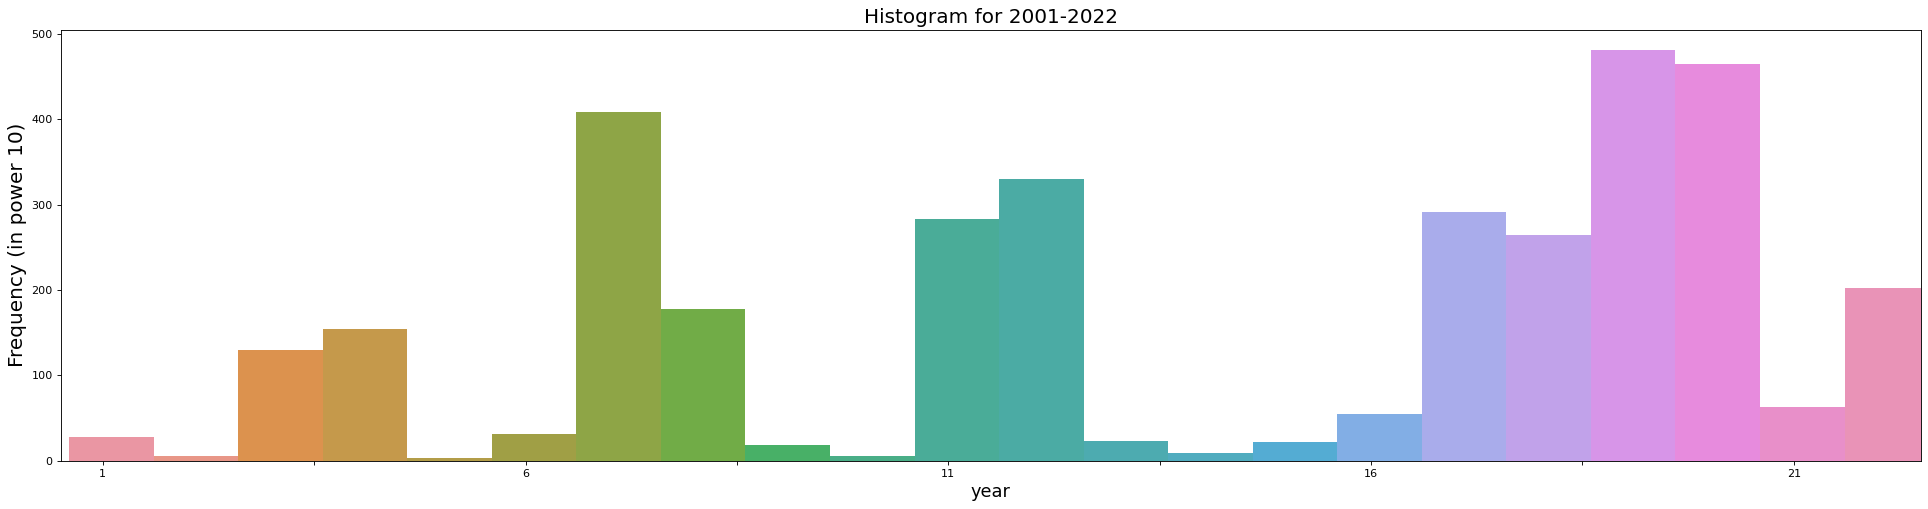

In [25]:

histogramDictionary = treeloss_year.reduceRegion(**{
 'reducer': ee.Reducer.histogram(30),
 'geometry': piura_shp,
 'scale': 30,
 'maxPixels': 1e19
})

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())

y = histogram['lossyear']['histogram']
x = []
for i in range(len(y)):
   x.append(histogram['lossyear']['bucketMin'] + i * histogram['lossyear']['bucketWidth'])
data = pd.DataFrame({'x': x, 'y': y})

fig, ax = plt.subplots(figsize=(30, 7), dpi=80)
sns.barplot(data=data, x='x', y='y', ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
for patch in ax.patches:
   current_height = patch.get_width()
   patch.set_width(1)
   patch.set_y(patch.get_y() + current_height - 1)
plt.title('Histogram for 2001-2022', fontsize=18)
plt.ylabel('Frequency (in power 10)', fontsize=18)
plt.xlabel('year', fontsize=16)